In [357]:
import pandas as pd
import geopandas as gpd
import numpy as np
import ipfn
from collections import OrderedDict
import matplotlib.pyplot as plt

% matplotlib inline

# Cake Map (Chapter 7)

## Preparing the input data

In [176]:
# There are 3 separate sets of constraints data to process.
# age-sex; cars; and, nssec.

# age-sex
# Age needs to be classified as: 16 to 24, 25 to 34, 35 to 44, 45 to 54, 55 to 64, 65 to 74, 75 and over
# Sex is male and female for each age group

age_sex = pd.read_csv(r'../data/cakemap/age-sex-raw.csv')
# Now extract the first row as a dictionary/lookup for the header row.
lookup = pd.Series(data = age_sex.iloc[0].values[5:], index = age_sex.columns[5:]).to_dict()

# Now remove the first row which contains the cross tab info
# And the second row which has county totals
age_sex.drop([0,1],axis=0,inplace=True)

# Reindex data
age_sex.reset_index(drop=True,inplace=True)

# Make fields numeric
age_sex = age_sex.apply(pd.to_numeric, errors='ignore')

# Create a dictionary of fields to make aggregation easy
columns = OrderedDict()
for sex in ['Male','Female']:
    for age_l, age_u in [[16,25],[25,35],[35,45],[45,55],[55,65],[65,75]]:
        # Construct a list of string values for searching the lookup table
        ages = np.arange(age_l,age_u,dtype=int).astype(str)
        fields = [field for field, name in lookup.items() if sex in name and any(age in name for age in ages)]
        columns[sex[0].lower() + str(age_l) + "_" + str(age_u-1)] = fields

# Now iterate over the dictionary to get aggregated values
age_sex_data = [age_sex['GEO_CODE']]
for key, fields in columns.items():
    age_sex_data.append(pd.Series(data = age_sex[fields].sum(axis=1), name = key))
# Finally, make a new dataframe
age_sex = pd.concat(age_sex_data, axis=1, keys=[s.name for s in age_sex_data])

# cars - F989 = total households; F991 = households with no car
cars = pd.read_csv(r'../data/cakemap/cars-raw.csv')
# Remove the first two rows
cars.drop([0,1],axis=0,inplace=True)
# Reindex data
cars.reset_index(drop=True,inplace=True)
# Make fields numeric
cars = cars.apply(pd.to_numeric, errors='ignore')
# Now just select the relevant columns
cars = cars[['GEO_CODE','F989','F991']]
# Need to take no cars or vans away from the total to get cars.
cars['F989'] = cars['F989'] - cars['F991']
# Rename columns
cars.rename(columns = {'F989':'Car','F991':'NoCar'}, inplace=True)

# nssec
nssec = pd.read_csv(r'../data/cakemap/nssec-raw.csv')
# Now extract the first row as a dictionary/lookup for the header row.
lookup = pd.Series(data = nssec.iloc[0].values[5:], index = nssec.columns[5:]).to_dict()

# Now remove the first row which contains the cross tab info
# And the second row which has county totals
nssec.drop([0],axis=0,inplace=True)

# Reindex data
nssec.reset_index(drop=True,inplace=True)

# Make fields numeric
nssec = nssec.apply(pd.to_numeric, errors='ignore')

# Subset nssec data
# NB This is the approach given in the example.
grades = [' 1.1',' 1.2','2. ','3. ','4. ','5. ','6. ','7. ','8. ','14.1','14.2','Not classified','15','17']
# However, I'm using this as I think 14.1 and 14.2 are covered by 8.
#grades = [' 1.1',' 1.2','2. ','3. ','4. ','5. ','6. ','7. ','8. ','Not classified','15','17']
columns = [field for field, name in lookup.items() if any(grade in name for grade in grades)]
nssec = nssec[['GEO_CODE'] + columns]

# Create others column
# For given example
others = [field for field, name in lookup.items() if any(grade in name for grade in ['14.1','14.2','Not classified','15','17'])]
# For revision without 14.1 and 14.2
#others = [field for field, name in lookup.items() if any(grade in name for grade in ['Not classified','15','17'])]
nssec['Other'] = nssec[others].sum(axis=1)
nssec.drop(others,axis=1,inplace=True) # Drop others columns

# rename remaining columns
nssec.rename(columns = {'F584':'X1.1','F588':'X1.2','F612':'X7','F592':'X2','F596':'X3',
                        'F616':'X8','F600':'X4','F604':'X5','F608':'X6'}, inplace=True)

# Finally, make sure columns are in a logical order
nssec = nssec[['GEO_CODE','X1.1','X1.2','X2','X3','X4','X5','X6','X7','X8','Other']]

In [180]:
# Now that we have cleaned each raw constraints data file, let's combine them all together.
# First, we want the constraints in each domain to add up to the same total.
# Currently they do not - this example takes the first ward
print 'age_sex total:', age_sex.iloc[0,range(1,13)].sum()
print 'cars total:', cars.iloc[0,[1,2]].sum()
print 'nssec total:', nssec.iloc[0,range(1,11)].sum()

# Therefore we'll just scale the cars and nssec values based on the row sums of age_sex
total = age_sex[age_sex.columns[1:]].sum(axis=1)
cars[['Car','NoCar']] = np.round(cars[['Car','NoCar']] * np.repeat(total / cars[['Car','NoCar']].sum(axis=1),2).reshape((len(cars),-1)))
nssec[nssec.columns[1:]] = np.round(nssec[nssec.columns[1:]] * np.repeat(total / nssec[nssec.columns[1:]].sum(axis=1),len(nssec.columns[1:])).reshape((len(nssec),-1)))

# Now merge everything together
cons = age_sex.merge(cars.merge(nssec, on= 'GEO_CODE'),on='GEO_CODE')

age_sex total: 11345.0
cars total: 11345.0
nssec total: 11345.0


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [196]:
# Now load the individual data
ind = pd.read_csv(r'../data/cakemap/ind.csv')
ind.head()

,NCakes,Car,Sex,NSSEC8,ageband4
0,3-5,2,1,7.0,25-34
1,1-2,2,2,2.0,55-64
2,1-2,1,2,2.0,45-54
3,6+,1,1,5.0,45-54
4,1-2,2,1,2.0,45-54


In [259]:
# THIS IS THE R SETUP
# This procedure produces the input ind_cat given by Lovelace.
# This data structure is effectively wide form.

# Now we need to restructure these data so that they match the constraints
# First make a dataframe of zeros with the same fields as cons
ind_catr = pd.DataFrame(np.zeros(shape=(len(ind),len(cons.columns[1:]))), columns=cons.columns[1:])
# Now iterate through the ind file and update the binary table as required.
for idx,row in ind.iterrows():
    # make age sex column indexer
    age_sex_col = ('m' if row['Sex'] == 1 else 'f') + row['ageband4'].replace('-','_')
    # update age_sex based on idx (row id) and column id
    ind_catr.loc[idx,age_sex_col] = 1
    # make car column indexer
    car_col = 'Car' if row['Car'] == 1 else 'NoCar'
    # update car col
    ind_catr.loc[idx, car_col] = 1
    # Make nssec column
    if row['NSSEC8'] in [2,3,4,5,6,7,8]:
        nssec_col = 'X' + str(row['NSSEC8'])[0]
    elif row['NSSEC8'] in [1.1,1.2]:
        nssec_col = 'X' + str(row['NSSEC8'])
    else:
        nssec_col = 'Other'
    # update nssec columns
    ind_catr.loc[idx,nssec_col] = 1

ind_catr.head()

,m16_24,m25_34,m35_44,m45_54,m55_64,m65_74,f16_24,f25_34,f35_44,f45_54,...,X1.1,X1.2,X2,X3,X4,X5,X6,X7,X8,Other
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
# THIS IS THE PYTHON IPFN SETUP
# This uses long data rather than wide data.
# The aim here is to make use the ind values are compatible with the columns in cons
# The columns are: age_sex, car, nssec
ind['age_sex'] = ind[['Sex','ageband4']].apply(lambda x: ('m' if x['Sex'] == 1 else 'f') + x['ageband4'].replace('-','_'),axis=1)
ind['car'] = ind['Car'].apply(lambda x: 'Car' if x == 1 else 'NoCar')

def nssec(ns):
    if ns in [2,3,4,5,6,7,8]:
        ns = 'X' + str(ns)[0]
    elif ns in [1.1,1.2]:
        ns = 'X' + str(ns)
    else:
        ns = 'Other'
    return ns
        
ind['nssec'] = ind['NSSEC8'].apply(lambda x: nssec(x))

ind_cat = ind[['age_sex','car','nssec']].copy()
ind_cat.head()

,age_sex,car,nssec
0,m25_34,NoCar,X7
1,f55_64,NoCar,X2
2,f45_54,Car,X2
3,m45_54,Car,X5
4,m45_54,NoCar,X2


## Iterative Proportional Fitting

In [256]:
# Use iterative proportional fitting to estimate weights for each zone (ward) in CakeMap
for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    age_sex = cons.iloc[i,range(1,13)]
    car = cons.iloc[i,range(13,15)]
    nssec = cons.iloc[i,range(15,25)]
    
    aggregates = [age_sex,car,nssec]
    dimensions = [['age_sex'],['car'],['nssec']]
    
    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance


In [258]:
# Check out the data table with all the weights.
ind_cat.head()

,nssec,age_sex,car,weight_E05001341,weight_E05001342,weight_E05001343,weight_E05001344,weight_E05001345,weight_E05001346,weight_E05001347,...,weight_E05001460,weight_E05001461,weight_E05001462,weight_E05001463,weight_E05001464,weight_E05008558,weight_E05008559,weight_E05008560,weight_E05008561,weight_E05008562
0,X7,m25_34,NoCar,5.992055,13.993448,7.453015,18.497378,53.033316,38.526123,6.412743e+01,...,47.453260,7.877050,15.267349,27.641565,9.054267,17.934046,14.498951,27.010025,8.313208,3.517665
1,X2,f55_64,NoCar,19.496646,29.493575,18.561116,13.191772,20.643096,13.164333,8.791399e+01,...,20.547386,11.541985,21.397010,18.696927,16.186044,24.901001,19.623929,24.497434,21.512595,12.075473
2,X2,f45_54,Car,14.109219,14.498880,16.026256,8.412325,3.780152,2.987218,6.556806e-08,...,6.420295,13.107023,8.381223,6.879329,11.498304,11.412768,13.102998,7.746004,13.308446,14.060899
3,X5,m45_54,Car,6.034378,5.876941,7.681305,5.495727,1.467119,0.961512,5.161336e-17,...,6.051627,8.438416,3.780803,5.125495,7.212487,5.866017,9.392604,3.334820,6.899939,5.302649
4,X2,m45_54,NoCar,15.283786,22.719276,15.121373,10.072882,5.758527,3.083629,7.722460e-08,...,18.507516,9.646799,13.352518,12.757111,13.793528,15.260077,17.520927,10.698412,15.799605,7.636228


In [289]:
# Now create the marginal distribution of individuals in each zone based on computed weights.
ind_agg = ind_catr.sum(axis=0)
ind_agg = cons.drop('GEO_CODE',axis=1).apply(lambda x: np.nan*ind_agg, axis=1)
# Now iterative over wards
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg.values.ravel(),cons.drop('GEO_CODE',axis=1).values.ravel())[0,1]

0.99685578305510725

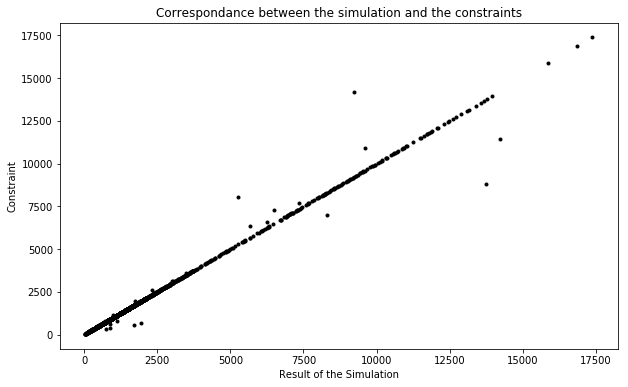

In [346]:
# Thi reproduces Figure 7.2 in Lovelace and Dumont
# There is a strong linear correlation between the simulation and constraints
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg.values.ravel(),cons.drop('GEO_CODE',axis=1).values.ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

In [311]:
# This is the maximum error
np.absolute(ind_agg.values - cons.drop('GEO_CODE',axis=1).values).max()

4960.2984296318082

In [316]:
# Where is the max error? 83 row, 12 column
# NB This is the same as Lovelace and Dumont; python counts from 0 and R from 1.
np.where(np.absolute(ind_agg - cons.drop('GEO_CODE',axis=1)) == np.absolute(ind_agg.values - cons.drop('GEO_CODE',axis=1).values).max())

(array([83], dtype=int64), array([12], dtype=int64))

## Integerisation and Expansion

In [418]:
# Truncate, replicate, sample 'TRS' integerisation approach.
def int_trs(weights):
    # convert to a vector if required
    xv = np.array(weights).ravel()
    # truncate - just get the integer part of the weight
    xint = np.floor(xv)
    # Get the decimal bit of the weight
    r = xv - xint
    # Work out the deficit population
    frac_sum = round(r.sum())
    # Sample based upon the deficit bit
    xs = np.random.choice(len(xv),int(frac_sum),True,r/r.sum())
    # Get the result of the deficit part
    topup = np.bincount(xs,minlength=len(xv))
    return xint + topup

def int_expand_vector(weights):
    return np.repeat(range(0,len(weights)),weights.astype(int))

In [419]:
indivs = []
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    # Integerise and expand - gives a list of the ind ids for the ward
    ints = int_expand_vector(int_trs(ind_cat['weight_'+ ward]))
    # Select the relevant individuals and cols
    temp = ind.iloc[ints][['NCakes','Car','Sex','NSSEC8','ageband4']]
    temp['ward'] = ward
    indivs.append(temp)
ints_df = pd.concat(indivs)
ints_df.reset_index(inplace=True)
ints_df.head()

,index,NCakes,Car,Sex,NSSEC8,ageband4,ward
0,0,3-5,2,1,7.0,25-34,E05001341
1,0,3-5,2,1,7.0,25-34,E05001341
2,0,3-5,2,1,7.0,25-34,E05001341
3,0,3-5,2,1,7.0,25-34,E05001341
4,0,3-5,2,1,7.0,25-34,E05001341


In [420]:
# To estimate cake consumption per zone we need to make 'NCakes' numeric.
ints_df['NCakes'].unique()

array(['3-5', '1-2', '6+', '<1', 'rarely'], dtype=object)

In [421]:
# First I'll make a dictionary that maps the text responses to a number.
cakes_num = {'3-5':4.0, '1-2':1.5, '6+':8.0, '<1':0.5, 'rarely':0.1}
# Now create a new numeric field
ints_df['NCakes_num'] = ints_df['NCakes'].apply(lambda x: cakes_num[x])

In [422]:
# the overall mean cake consumption is
ints_df['NCakes_num'].mean()

3.4171534478437118

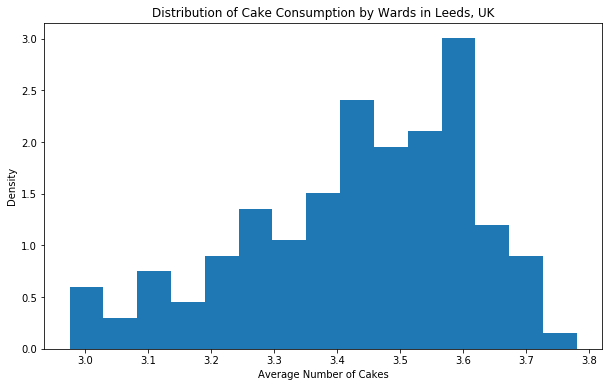

In [423]:
# We can use a groupby to get means for wards
ward_cakes = ints_df.groupby('ward')['NCakes_num'].mean().to_frame()
f, ax = plt.subplots(figsize=(10,6))
ax.hist(ward_cakes['NCakes_num'],density=True, bins=15)
ax.set_xlabel('Average Number of Cakes')
ax.set_ylabel('Density')
ax.set_title('Distribution of Cake Consumption by Wards in Leeds, UK');

# There isn't actually a massive amount of heterogeneity in mean cake consumption
# Less than 1 cake, on average, between the most and least cake consuming wards.

## Geovisualisation

In [424]:
# First read in the wards file using geopandas
wards = gpd.read_file(r'../data/cakemap/wards.geojson')
wards.head()

,CODE,OLDCODE,NAME,geometry
0,E05001440,00DAHS,Roundhay,"POLYGON ((432963.2996 439234.9012, 434207.7996..."
1,E05001436,00DAHN,Morley South,"POLYGON ((428588.5996 427861.3004, 427786.5004..."
2,E05001423,00DAGZ,Garforth and Swillington,"POLYGON ((443241.0996 434887.798, 442978.9003 ..."
3,E05001410,00CZHA,Newsome,"POLYGON ((414456.7995 417211.3994, 415109.8023..."
4,E05001405,00CZGU,Holme Valley South,"POLYGON ((416558.9015 409794.9974, 417742.7991..."


In [425]:
# Now, merge in the cake info
wards = wards.merge(ward_cakes, left_on='CODE', right_index=True)

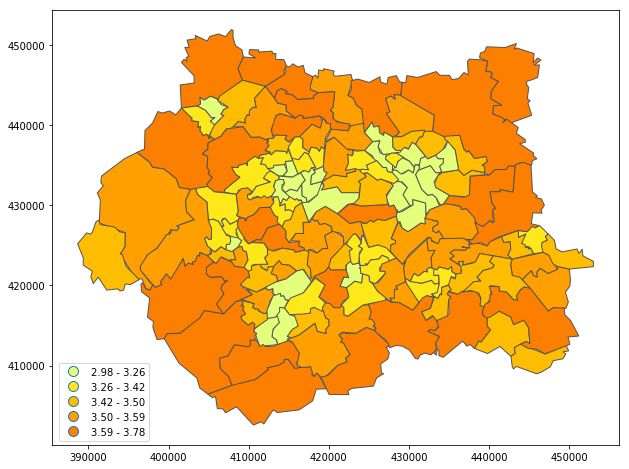

In [426]:
# Finally, draw the average cake consumption map
f, ax = plt.subplots(figsize = (12,8))
wards.plot(column = 'NCakes_num', cmap = 'Wistia', scheme = 'Quantiles', edgecolor='0.33', legend=True, ax=ax)
ax.set_aspect('equal')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.18, 0.2))